**# Step 1: Import Libraries**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

**# Step 2: Load Dataset and Check info**

In [30]:
df = pd.read_csv("/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [32]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [33]:
df.shape

(614, 13)

**Step 3: Exploratory Data Analysis (EDA)**

**Class Distribution**

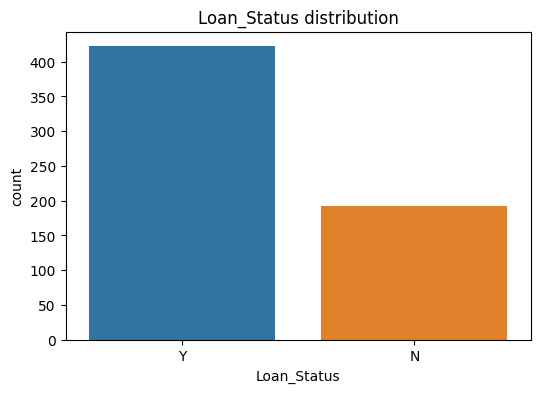

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan_Status distribution")
plt.show()

**Categorical Features Bar Plots**

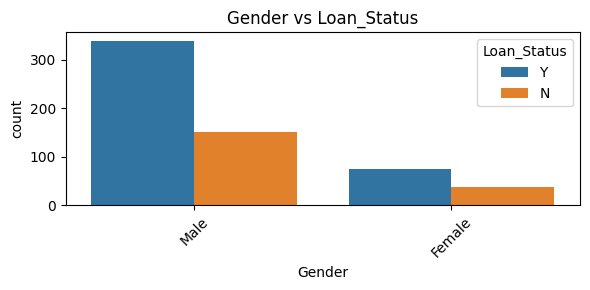

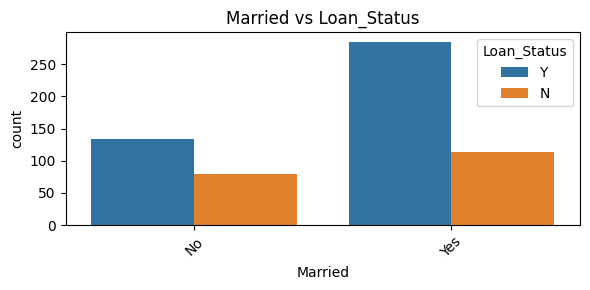

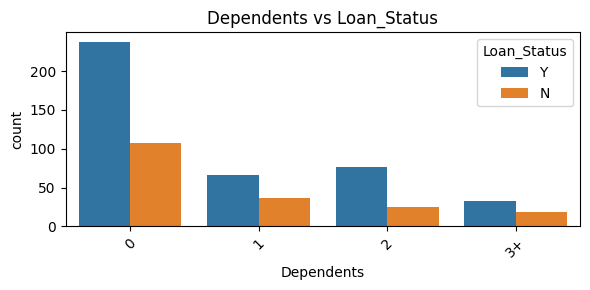

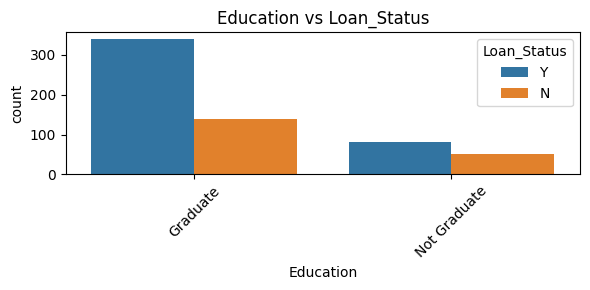

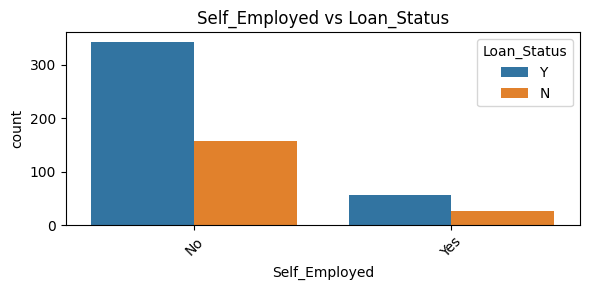

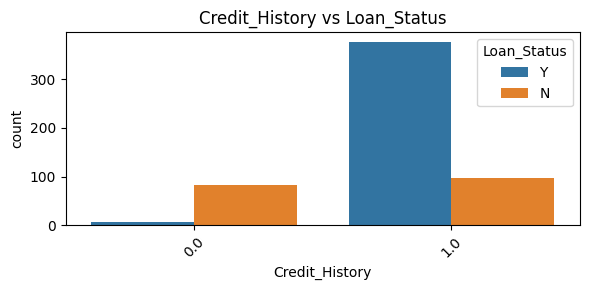

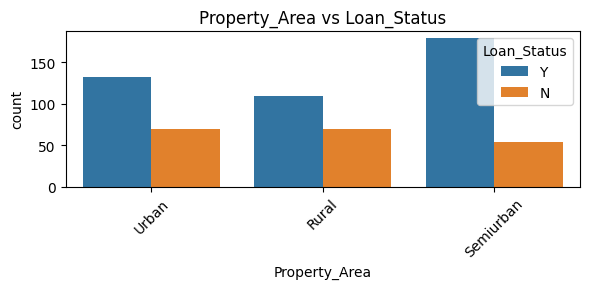

In [35]:
cat_cols = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
cat_cols = [c for c in cat_cols if c in df.columns]

for c in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=c, hue='Loan_Status')
    plt.title(f"{c} vs Loan_Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Numerical Distributions**

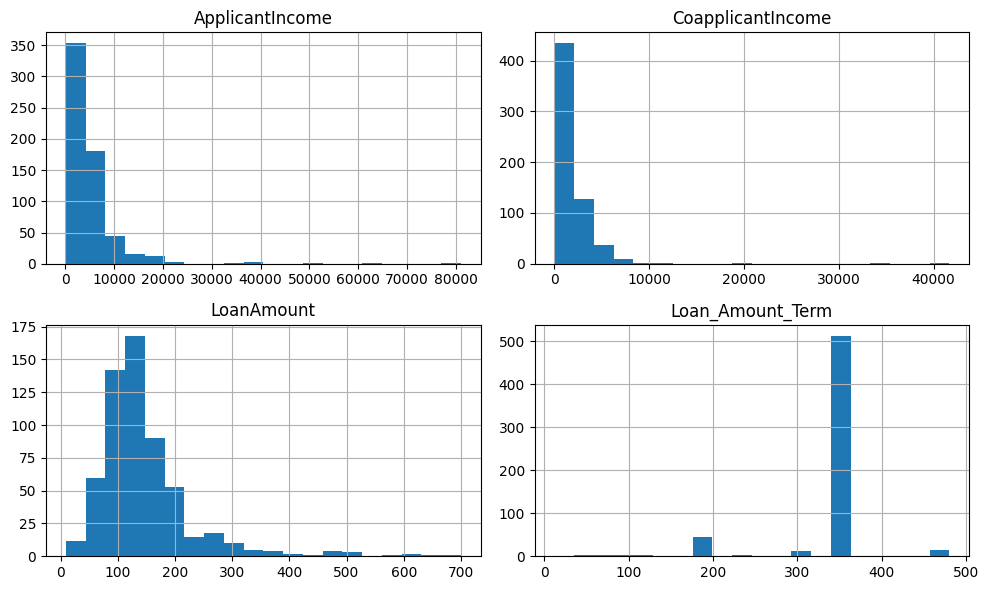

In [36]:
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
num_cols = [c for c in num_cols if c in df.columns]
df[num_cols].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()

**Correlation Heatmap on Numeric Columns**

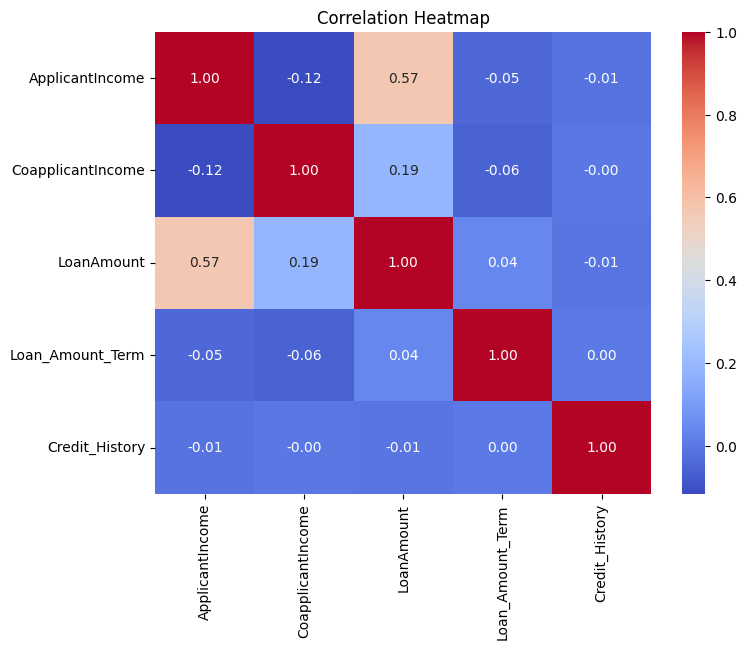

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

**Boxplots to Detect Outliers**

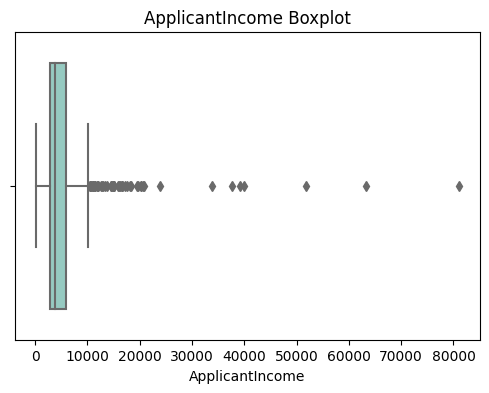

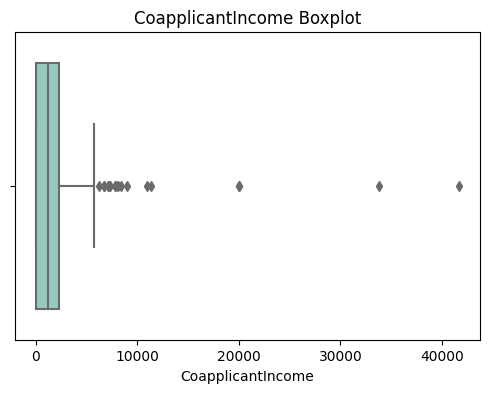

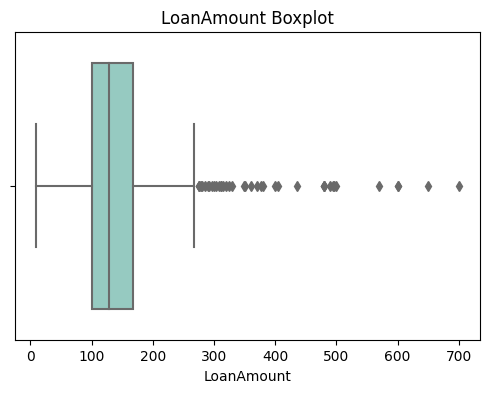

In [38]:
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], palette="Set3")
    plt.title(f"{col} Boxplot")
    plt.show()

**Missing Values Heatmap**

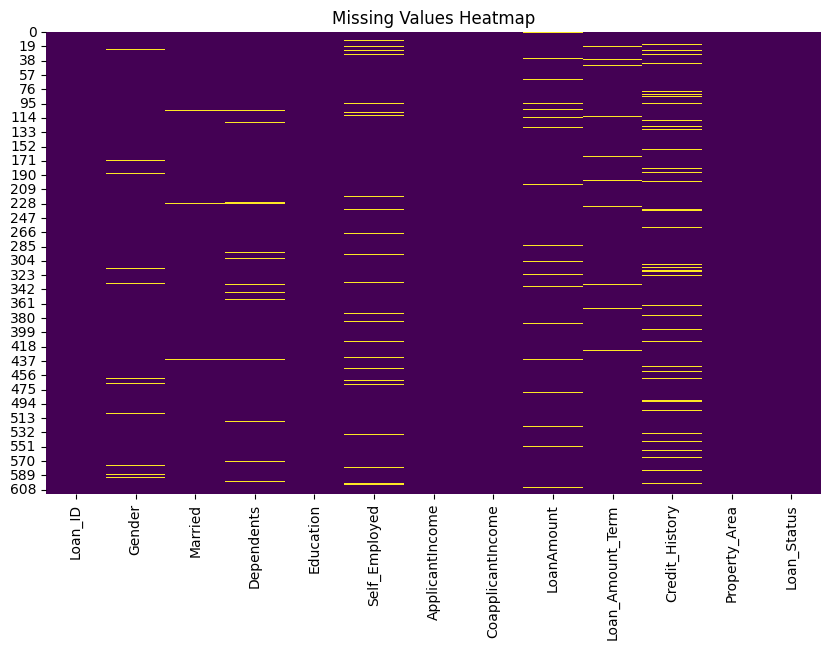

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

**Step 4: Feature Engineering**

In [40]:
df['Dependents'] = df['Dependents'].replace('3+', 3)
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

df['TotalIncome'] = df['ApplicantIncome'].fillna(0) + df['CoapplicantIncome'].fillna(0)
df['Log_ApplicantIncome'] = np.log1p(df['ApplicantIncome'].replace(0, np.nan))
df['Log_CoapplicantIncome'] = np.log1p(df['CoapplicantIncome'].replace(0, np.nan))
df['Log_TotalIncome'] = np.log1p(df['TotalIncome'].replace(0, np.nan))

df['Log_LoanAmount'] = np.log1p(df['LoanAmount'].replace(0, np.nan))
df['Loan_Amount_Term'] = pd.to_numeric(df['Loan_Amount_Term'], errors='coerce')
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

df['Income_Loan_Ratio'] = df['TotalIncome'] / (df['LoanAmount'].replace(0, np.nan))

df['Married_flag'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Education_flag'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,Loan_Status,TotalIncome,Log_ApplicantIncome,Log_CoapplicantIncome,Log_TotalIncome,Log_LoanAmount,EMI,Income_Loan_Ratio,Married_flag,Education_flag
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,...,Y,5849.0,8.674197,NaN,8.674197,NaN,NaN,NaN,0.0,1
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,...,N,6091.0,8.430327,7.319202,8.714732,4.859812,0.355556,47.585938,1.0,1
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,...,Y,3000.0,8.006701,NaN,8.006701,4.204693,0.183333,45.454545,1.0,1
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,...,Y,4941.0,7.857094,7.765993,8.505525,4.795791,0.333333,41.175000,1.0,0
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,...,Y,6000.0,8.699681,NaN,8.699681,4.955827,0.391667,42.553191,0.0,1


**Step 5: Data Preprocessing and Split into train/validation**

In [41]:
cols_to_drop = [
    'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'
]
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

if 'Loan_Status' in df.columns:
    df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

df = df.dropna(subset=['Loan_Status'])
df['Loan_Status'] = df['Loan_Status'].astype(int)

feature_cols = [col for col in df.columns if col not in ['Loan_ID', 'Loan_Status']]

In [42]:
X = df[feature_cols].copy()
y = df['Loan_Status'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)


In [43]:
X.head()

,Credit_History,Property_Area,TotalIncome,Log_ApplicantIncome,Log_CoapplicantIncome,Log_TotalIncome,Log_LoanAmount,EMI,Income_Loan_Ratio,Married_flag,Education_flag
0,1.0,Urban,5849.0,8.674197,NaN,8.674197,NaN,NaN,NaN,0.0,1
1,1.0,Rural,6091.0,8.430327,7.319202,8.714732,4.859812,0.355556,47.585938,1.0,1
2,1.0,Urban,3000.0,8.006701,NaN,8.006701,4.204693,0.183333,45.454545,1.0,1
3,1.0,Urban,4941.0,7.857094,7.765993,8.505525,4.795791,0.333333,41.175000,1.0,0
4,1.0,Urban,6000.0,8.699681,NaN,8.699681,4.955827,0.391667,42.553191,0.0,1


**Step 6: Build Preprocessing Pipeline**

In [44]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

**Step 7: Define Models**

In [45]:
models_untuned = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42)
}

pipelines_untuned = {name: Pipeline([('preprocessor', preprocessor), ('clf', clf)]) for name, clf in models_untuned.items()}

**Step 8: Train untuned models and evaluate**

In [46]:
results_untuned = {}
best_model_name = None
best_accuracy = 0

for name, pipe in pipelines_untuned.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
   
    try:
        y_proba = pipe.predict_proba(X_valid)[:,1]
        roc = roc_auc_score(y_valid, y_proba)
    except Exception:
        try:
            y_score = pipe.decision_function(X_valid)
            roc = roc_auc_score(y_valid, y_score)
            y_proba = None
        except Exception:
            roc = np.nan
            y_proba = None

    results_untuned[name] = {
        'pipeline': pipe,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name

print("\nUntuned Model accuracies:")
for model_name, metrics in results_untuned.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}")

print(f"\nBest model is '{best_model_name}' with accuracy = {best_accuracy:.4f}")


Untuned Model accuracies:
LogisticRegression: Accuracy = 0.8537
RandomForest: Accuracy = 0.8862
GradientBoosting: Accuracy = 0.8537
KNN: Accuracy = 0.8130
SVC: Accuracy = 0.8537

Best model is 'RandomForest' with accuracy = 0.8862


**ROC curves for all untuned models**

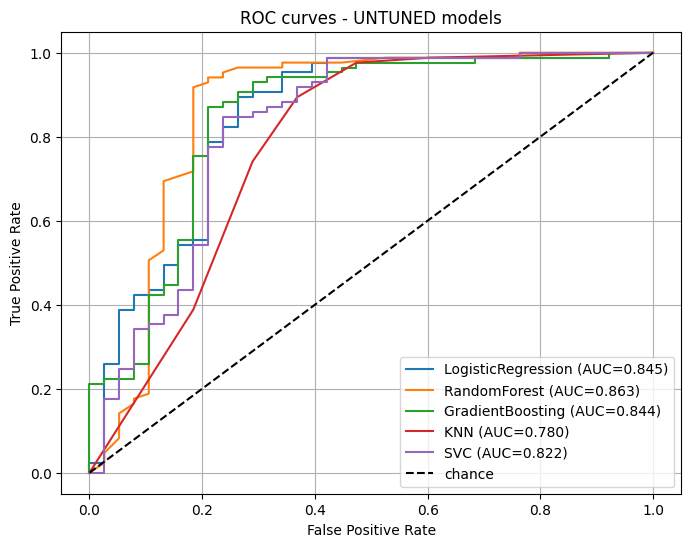

In [47]:
plt.figure(figsize=(8,6))
for name, res in results_untuned.items():
    y_proba = res['y_proba']
    if y_proba is None:
        # try to get probability again (some models)
        try:
            y_proba = res['pipeline'].predict_proba(X_valid)[:,1]
        except Exception:
            continue
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], 'k--', label='chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves - UNTUNED models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Confusion Matrix & Classification Report for best untuned model**

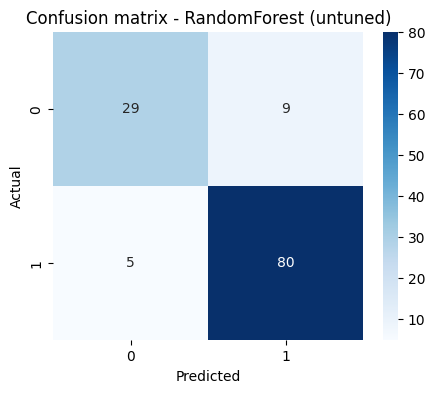


Classification report (best untuned):
              precision    recall  f1-score   support

           0     0.8529    0.7632    0.8056        38
           1     0.8989    0.9412    0.9195        85

    accuracy                         0.8862       123
   macro avg     0.8759    0.8522    0.8625       123
weighted avg     0.8847    0.8862    0.8843       123



In [48]:
best_untuned = results_untuned[best_model_name]['pipeline']
y_pred_best_untuned = results_untuned[best_model_name]['y_pred']

cm = confusion_matrix(y_valid, y_pred_best_untuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix - {best_model_name} (untuned)')
plt.show()

print("\nClassification report (best untuned):")
print(classification_report(y_valid, y_pred_best_untuned, digits=4))

**Step 9: Hyperparameter grids for tuning**

In [49]:
param_grids = {
    'LogisticRegression': {'clf__C': [0.01, 0.1, 1, 10]},
    'RandomForest': {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 6, 12]},
    'GradientBoosting': {'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.05, 0.1], 'clf__max_depth': [3, 6]},
    'KNN': {'clf__n_neighbors': [3,5,7]},
    'SVC': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['rbf','linear']}
}

**Train tuned models and evaluate**

In [50]:
tuned_results = {}
for name, base_pipe in pipelines_untuned.items():
    grid = GridSearchCV(base_pipe, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    y_pred = best_pipe.predict(X_valid)
    try:
        y_proba = best_pipe.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_proba)
    except Exception:
        y_proba = None
        try:
            roc = roc_auc_score(y_valid, best_pipe.decision_function(X_valid))
        except Exception:
            roc = np.nan
    
    tuned_results[name] = {
        'grid_search': grid,
        'pipeline': best_pipe,
        'best_params': grid.best_params_,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'accuracy': accuracy_score(y_valid, y_pred),
        'precision': precision_score(y_valid, y_pred, zero_division=0),
        'recall': recall_score(y_valid, y_pred, zero_division=0),
        'f1': f1_score(y_valid, y_pred, zero_division=0),
        'roc_auc': roc
    }
    
print("\nUntuned Model accuracies:")
for model_name, metrics in results_untuned.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}")

print(f"\nBest model is '{best_model_name}' with accuracy = {best_accuracy:.4f}")


Untuned Model accuracies:
LogisticRegression: Accuracy = 0.8537
RandomForest: Accuracy = 0.8862
GradientBoosting: Accuracy = 0.8537
KNN: Accuracy = 0.8130
SVC: Accuracy = 0.8537

Best model is 'RandomForest' with accuracy = 0.8862


**ROC curves for all tuned models**

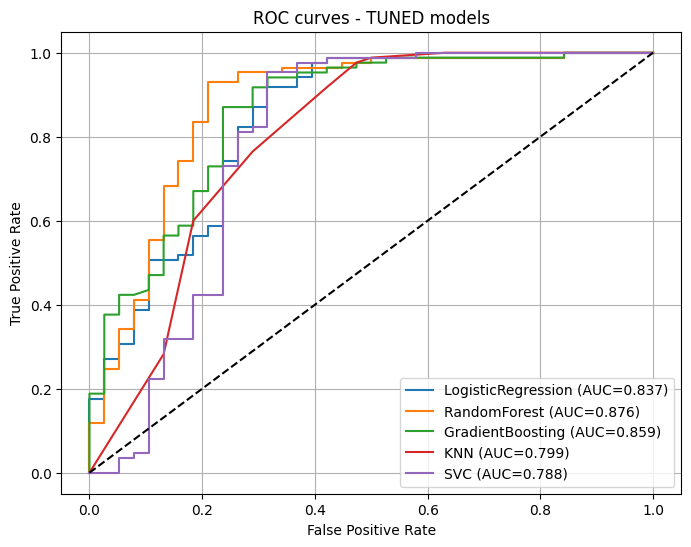

In [51]:
plt.figure(figsize=(8,6))
for name, res in tuned_results.items():
    y_proba = res['y_proba']
    if y_proba is None:
        try:
            y_proba = res['pipeline'].predict_proba(X_valid)[:,1]
        except Exception:
            continue
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves - TUNED models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Confusion Matrix & Classification Report for best tuned model**

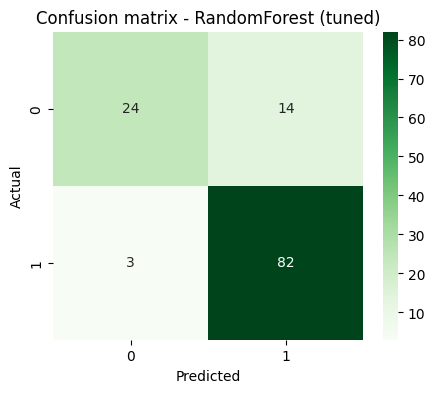


Classification report (best tuned): RandomForest
              precision    recall  f1-score   support

           0     0.8889    0.6316    0.7385        38
           1     0.8542    0.9647    0.9061        85

    accuracy                         0.8618       123
   macro avg     0.8715    0.7981    0.8223       123
weighted avg     0.8649    0.8618    0.8543       123



In [52]:
best_tuned_name = max(tuned_results.items(), key=lambda x: x[1]['accuracy'])[0]
best_tuned = tuned_results[best_tuned_name]['pipeline']
y_pred_best_tuned = tuned_results[best_tuned_name]['y_pred']

cm = confusion_matrix(y_valid, y_pred_best_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix - {best_tuned_name} (tuned)')
plt.show()

print(f"\nClassification report (best tuned): {best_tuned_name}")
print(classification_report(y_valid, y_pred_best_tuned, digits=4))

**Step 10: Accuracy Comparison**

In [53]:
df_untuned = pd.DataFrame([
    {'model': name, 'accuracy_untuned': metrics['accuracy']}
    for name, metrics in results_untuned.items()
])
df_tuned = pd.DataFrame([
    {'model': name, 'accuracy_tuned': metrics['accuracy']}
    for name, metrics in tuned_results.items()
])

accuracy_compare = pd.merge(df_untuned, df_tuned, on='model', how='outer').fillna('-')

print("Accuracy comparison (untuned vs tuned):")
display(accuracy_compare.sort_values(by='accuracy_untuned', ascending=False))

Accuracy comparison (untuned vs tuned):


,model,accuracy_untuned,accuracy_tuned
3,RandomForest,0.886179,0.861789
0,GradientBoosting,0.853659,0.845528
2,LogisticRegression,0.853659,0.853659
4,SVC,0.853659,0.853659
1,KNN,0.813008,0.813008


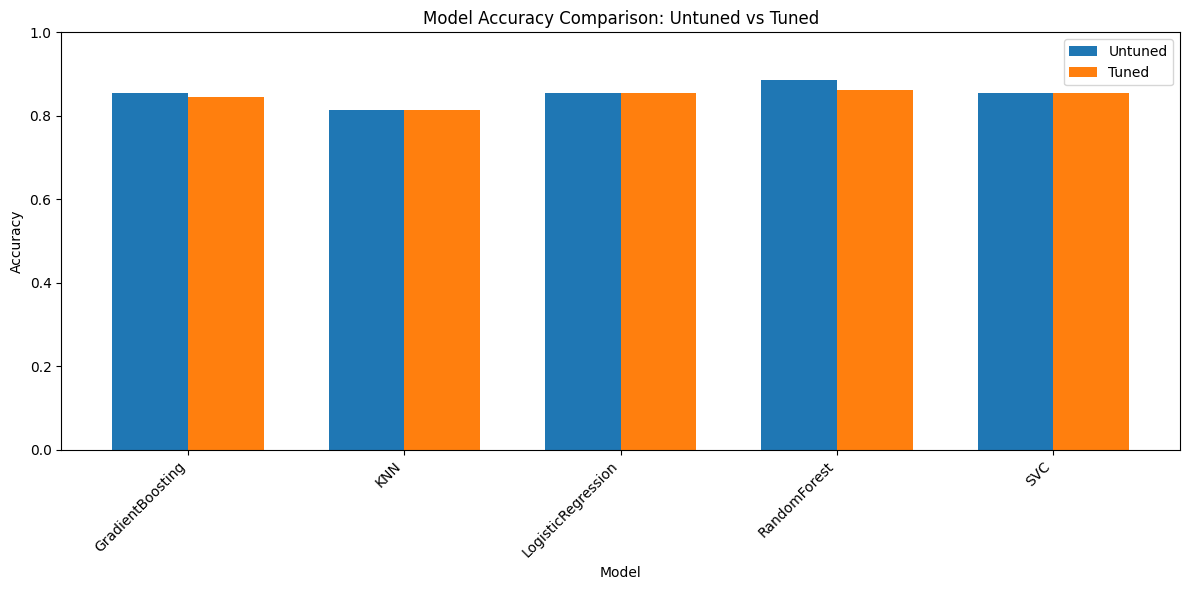

In [54]:
accuracy_compare_plot = accuracy_compare.copy()
accuracy_compare_plot['accuracy_untuned'] = pd.to_numeric(accuracy_compare_plot['accuracy_untuned'], errors='coerce')
accuracy_compare_plot['accuracy_tuned'] = pd.to_numeric(accuracy_compare_plot['accuracy_tuned'], errors='coerce')

bar_width = 0.35
index = np.arange(len(accuracy_compare_plot))
plt.figure(figsize=(12,6))

plt.bar(index, accuracy_compare_plot['accuracy_untuned'], bar_width, label='Untuned')
plt.bar(index + bar_width, accuracy_compare_plot['accuracy_tuned'], bar_width, label='Tuned')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Untuned vs Tuned')
plt.xticks(index + bar_width / 2, accuracy_compare_plot['model'], rotation=45, ha='right')
plt.ylim(0, 1) 
plt.legend()
plt.tight_layout()
plt.show()

**Step 11: Prediction Comparison**

In [55]:
untuned_best_name = max(results_untuned.items(), key=lambda x: x[1]['accuracy'])[0]
untuned_best_pipe = results_untuned[untuned_best_name]['pipeline']

if tuned_results:
    tuned_best_name = max(tuned_results.items(), key=lambda x: x[1]['accuracy'])[0]
    tuned_best_pipe = tuned_results[tuned_best_name]['pipeline']
else:
    tuned_best_name = None
    tuned_best_pipe = None

pred_df = pd.DataFrame({'Actual': y_valid.values})
pred_df[f'Untuned_{untuned_best_name}'] = untuned_best_pipe.predict(X_valid)

if tuned_best_pipe is not None:
    pred_df[f'Tuned_{tuned_best_name}'] = tuned_best_pipe.predict(X_valid)
else:
    pred_df['Tuned_pred'] = np.nan

label_map = {1: 'Y', 0: 'N'}
pred_df_display = pred_df.copy()
pred_df_display['Actual_label'] = pred_df_display['Actual'].map(label_map)

for col in pred_df_display.columns:
    if col.startswith('Untuned_') or col.startswith('Tuned_'):
        pred_df_display[col + '_label'] = pred_df_display[col].map(label_map)

print("\nPrediction comparison:")
cols_to_show = ['Actual_label']
cols_to_show.append(f'Untuned_{untuned_best_name}_label')
cols_to_show.append(f'Tuned_{tuned_best_name}_label')

display(pred_df_display[cols_to_show].head(10))


Prediction comparison:


,Actual_label,Untuned_RandomForest_label,Tuned_RandomForest_label
0,N,N,N
1,Y,Y,Y
2,Y,Y,Y
3,Y,Y,Y
4,Y,Y,Y
5,N,Y,Y
6,Y,Y,Y
7,Y,Y,Y
8,Y,Y,Y
9,Y,Y,Y
